In [43]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image

In [29]:
excel_file="data.xlsx"

In [30]:
data = pd.read_excel(excel_file, sheet_name=None)
mandarin_data = data["Mandarin"]
peach_data = data["Peach"]
tomato_data = data["Tomato"]
#cucumber_data = data["cucumber"]

data = pd.read_excel(excel_file, sheet_name=None, skiprows=1)
lemon_data = data["Lemon"]

In [31]:
# Mandarin
mandarin_data_top = mandarin_data[["file name", "% spoiled"]]
mandarin_data_top.dropna(inplace=True)

mandarin_data_side = mandarin_data[["file name.1", "% spoiled.1"]]

mandarin_data_side.rename(
    columns={"file name.1": "file name", "% spoiled.1": "% spoiled"}, inplace=True
)
mandarin_data_side.dropna(inplace=True)

# Lemon
lemon_data_top = lemon_data[["File name", "% Waste"]]
lemon_data_top.dropna(inplace=True)

lemon_data_side = lemon_data[["File name.1", "% Waste.1"]]

lemon_data_side.rename(
    columns={"File name.1": "File name", "% Waste.1": "% Waste"}, inplace=True
)
lemon_data_side.dropna(inplace=True)


# Peach
peach_data_top = peach_data[["File name", "% Waste"]]
peach_data_top.dropna(inplace=True)

peach_data_side = peach_data[["File name.1", "% Waste.1"]]

peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
peach_data_side.dropna(inplace=True)


# Tomato
tomato_data_top = tomato_data[["File name", "% Waste"]]
tomato_data_top.dropna(inplace=True)

tomato_data_side = tomato_data[["File name.1", "% Waste.1"]]

tomato_data_side.rename(
    columns={"File name.1": "File name", "% Waste.1": "% Waste"}, inplace=True
)
tomato_data_side.dropna(inplace=True)


"""# Cucumber
cucumber_data = cucumber_data[["File name", "% waste"]]

cucumber_data.rename(
    columns={"% waste": "% Waste"}, inplace=True
)

cucumber_data.dropna(inplace=True)"""

C:\Users\user\AppData\Local\Temp\ipykernel_21760\4068642717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandarin_data_top.dropna(inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21760\4068642717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandarin_data_side.rename(
C:\Users\user\AppData\Local\Temp\ipykernel_21760\4068642717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandarin_data_side.dropna(inplace=Tr

'# Cucumber\ncucumber_data = cucumber_data[["File name", "% waste"]]\n\ncucumber_data.rename(\n    columns={"% waste": "% Waste"}, inplace=True\n)\n\ncucumber_data.dropna(inplace=True)'

In [32]:
mandarin_data_side = mandarin_data_side.rename(
    columns={"file name": "File name", "% spoiled": "% Waste"}
)

mandarin_data_top = mandarin_data_top.rename(
    columns={"file name": "File name", "% spoiled": "% Waste"}
)

data = pd.concat(
    [
        mandarin_data_side,
        mandarin_data_top,
        peach_data_side,
        peach_data_top,
        lemon_data_side,
        lemon_data_top,
        tomato_data_side,
        tomato_data_top
    ],
    axis=0,
)

data["File name"] = data["File name"].str.replace("mandarine", "mandarin")


display(data)

File name     % Waste
0    20240104_mandarin_01_side_01  100.000000
1    20240104_mandarin_02_side_01   63.909774
2    20240104_mandarin_03_side_01   21.256039
3    20240104_mandarin_04_side_01   17.600000
4    20240104_mandarin_05_side_01   18.852459
..                            ...         ...
151     20240502_tomato_20_top_01  100.000000
152     20240502_tomato_21_top_01  100.000000
153     20240502_tomato_22_top_01  100.000000
154     20240502_tomato_23_top_01  100.000000
155     20240502_tomato_24_top_01  100.000000

[975 rows x 2 columns]

In [33]:
# Extracting fruit name from file name
data["Fruit"] = data["File name"].apply(lambda x: x.split("_")[1])

# Counting the number of images for each fruit
images_per_fruit = data["Fruit"].value_counts()

print("Number of images per fruit:")
print(images_per_fruit)

Number of images per fruit:
Fruit
tomato      278
peach       255
mandarin    232
lemon       210
Name: count, dtype: int64


<Axes: >

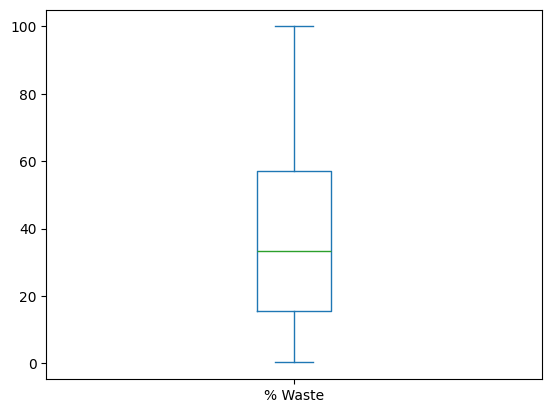

In [34]:
data.plot(kind="box")

In [35]:
actual_waste = data["% Waste"]
baseline_prediction = np.mean(data["% Waste"])

# Generate baseline predictions for all samples
baseline_predictions = np.full_like(actual_waste, baseline_prediction)

# Calculate RMSE for baseline predictions
baseline_rmse = np.sqrt(mean_squared_error(actual_waste, baseline_predictions))


print("Baseline RMSE:", baseline_rmse)

Baseline RMSE: 29.613284849823934


### Split data keeping ratio same

In [36]:
# Define a function to split data for each fruit separately
def split_data_by_fruit(dataframe, test_size=0.2, random_state=42):
    train_dfs = []
    test_dfs = []
    fruits = (
        dataframe["File name"].apply(lambda x: x.split("_")[1]).unique()
    )  # Extract fruit name
    for fruit in fruits:
        fruit_df = dataframe[dataframe["File name"].str.contains(fruit)]
        train_fruit_df, test_fruit_df = train_test_split(
            fruit_df, test_size=test_size, random_state=random_state
        )
        train_dfs.append(train_fruit_df)
        test_dfs.append(test_fruit_df)
    return pd.concat(train_dfs), pd.concat(test_dfs)


Extraction Color Histograms and Training Models

In [37]:
counter_missing_images = 0
missing_images_per_fruit = {}


# Function to extract histogram features from image files
def extract_histogram(image_path):
    global counter_missing_images
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise Exception(f"Failed to open image '{image_path}'")
        hist = cv2.calcHist(
            [image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
        )
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except Exception as e:
        # Attempt to read the image with a capitalized ".JPG" extension
        image_path_jpg = image_path[:-4] + ".JPG"
        try:
            image = cv2.imread(image_path_jpg)
            if image is None:
                raise Exception(
                    f"Failed to open image '{image_path}' and '{image_path_jpg}'"
                )
            hist = cv2.calcHist(
                [image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
            )
            hist = cv2.normalize(hist, hist).flatten()
            return hist
        except Exception as e:
            fruit_name = os.path.basename(image_path).split("_")[
                1
            ]  # Extract fruit name from image path
            if fruit_name not in missing_images_per_fruit:
                missing_images_per_fruit[fruit_name] = 1
            else:
                missing_images_per_fruit[fruit_name] += 1
            counter_missing_images += 1
            return None


folder = "all_images"

# Extracting histogram features for train and test data
data["Histogram"] = data["File name"].apply(
    lambda x: extract_histogram(os.path.join(folder, x + ".jpg"))
)

# Remove rows where histogram extraction failed
data = data.dropna()

# Print out the count of fruits for which images are missing
print("Number of fruits with missing images:")
for fruit, count in missing_images_per_fruit.items():
    print(f"{fruit}: {count} image(s) missing")

# Print out the total count of missing images
print(f"Total number of missing images: {counter_missing_images}")

Number of fruits with missing images:
mandarin: 7 image(s) missing
peach: 7 image(s) missing
lemon: 24 image(s) missing
tomato: 96 image(s) missing
Total number of missing images: 134


In [38]:
train_df, test_df = split_data_by_fruit(data)

# Preparing features and target for training and testing
X_train = np.vstack(train_df["Histogram"]).astype(float)
y_train = train_df["% Waste"]
X_test = np.vstack(test_df["Histogram"]).astype(float)
y_test = test_df["% Waste"]

In [39]:
print(
    f"Train Dataset: {len(train_df)}\
      Test Dataset: {len(test_df)}"
)

Train Dataset: 671      Test Dataset: 170


Random Forest: RMSE = 18.45433533768214
XGBoost: RMSE = 18.487911898405315
SVR: RMSE = 21.687215894717053


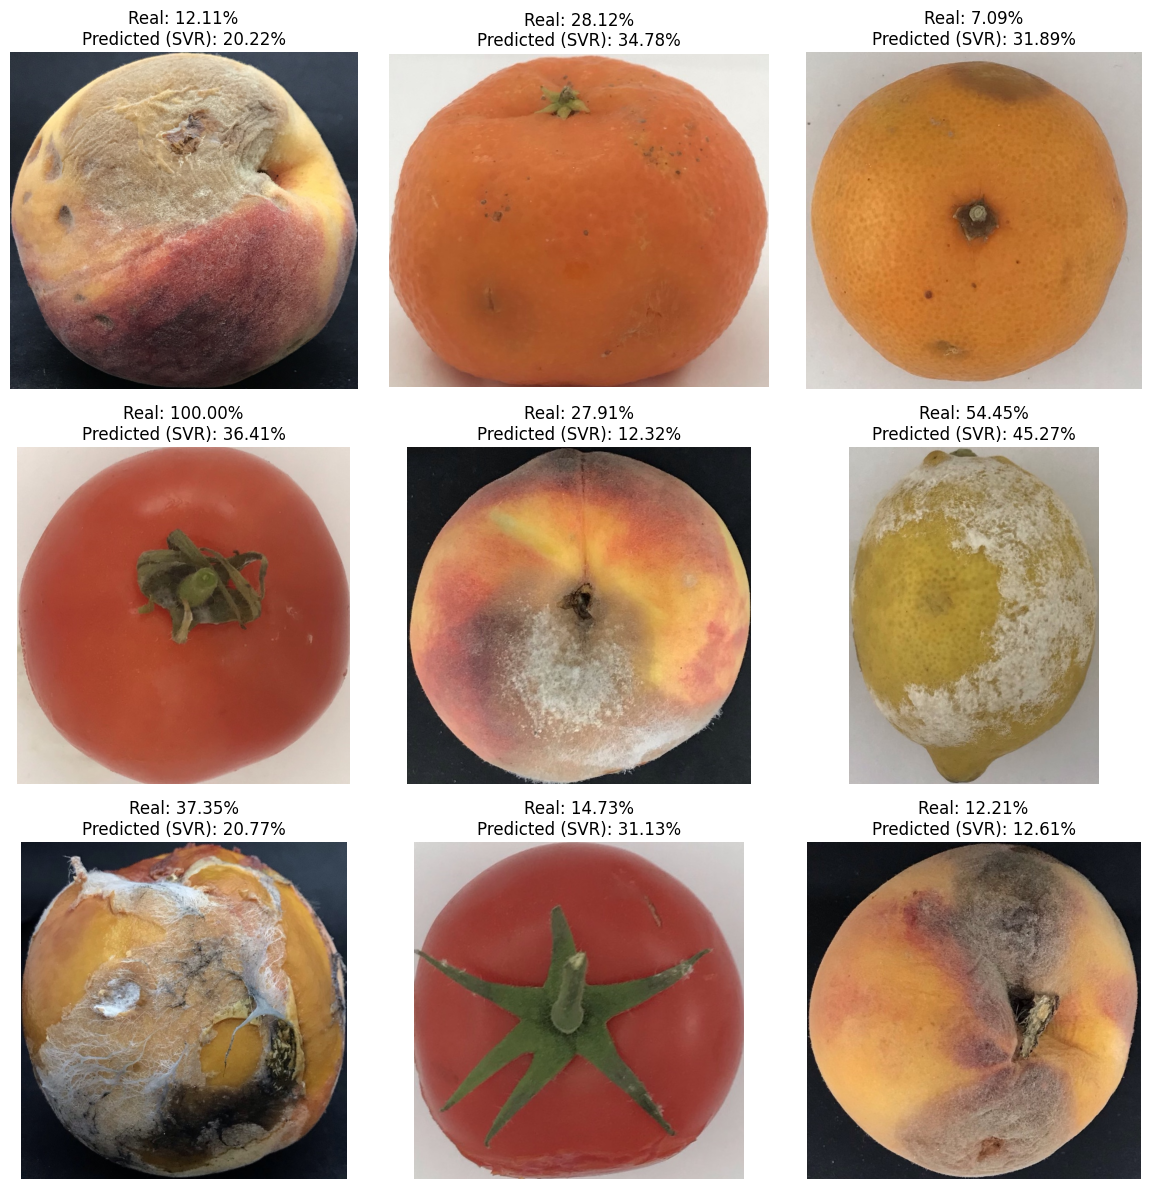

In [40]:
# Train regression models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
}

predicted_values = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE = {rmse}")
    predicted_values[name] = y_pred

# Select random images from the test set
num_samples = 9
random_indices = random.sample(range(len(test_df)), num_samples)

# Display images and real/predicted waste percentages
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices, 1):
    image_name = test_df.iloc[idx]["File name"]
    image_path = os.path.join(folder, image_name + ".jpg")
    image = cv2.imread(image_path)
    real_waste = test_df.iloc[idx]["% Waste"]
    plt.subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Real: {real_waste:.2f}%\nPredicted:")
    for model_name, predictions in predicted_values.items():
        plt.gca().set_title(
            f"Real: {real_waste:.2f}%\nPredicted ({model_name}): {predictions[idx]:.2f}%"
        )
    plt.axis("off")

plt.tight_layout()
plt.show()

## DL Based Regression

In [58]:
train_df, temp = split_data_by_fruit(data,test_size=0.22)
val_df, test_df = split_data_by_fruit(temp, test_size=0.5)

len(train_df), len(val_df), len(test_df)

(654, 92, 95)

In [59]:
from torchvision import transforms


class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.fruit_indices = {}  # Initialize a regular dictionary
        for idx, row in self.dataframe.iterrows():
            fruit_name = row["File name"].split("_")[
                1
            ]  # Extract fruit name from the file name
            if fruit_name not in self.fruit_indices:
                self.fruit_indices[fruit_name] = (
                    []
                )  # Initialize an empty list for each fruit
            self.fruit_indices[fruit_name].append(idx)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".jpg")
        if not os.path.exists(img_name):
            return None, None
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 1]

        # Convert BGR image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Define image transformations
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Define datasets and data loaders
train_dataset = CustomDataset(train_df, "all_images", transform=train_transforms)
test_dataset = CustomDataset(test_df, "all_images", transform=test_transforms)
val_dataset = CustomDataset(val_df, "all_images", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Define the model
class RegressionModel(nn.Module):

    def __init__(self):

        super(RegressionModel, self).__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet.children())[:-1]
        )  # Remove the last fully connected layer
        self.regressor1 = nn.Linear(
            2048, 512
        )  # Replace the last layer with a regression layer
        self.regressor2 = nn.Linear(512, 64)
        self.regressor3 = nn.Linear(64, 1)

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor1(x)
        x = nn.GELU()(x)
        x = self.regressor2(x)
        x = nn.GELU()(x)
        x = self.regressor3(x)
        return x


# Define the model
model = RegressionModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Early stopping
best_val_loss = float("inf")
patience = 13
counter = 0
best_model_weights = None

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs.squeeze(), labels.float())
        val_running_loss += val_loss.item() * inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_epoch_loss)

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        # Save the best model weights
        best_model_weights = model.state_dict()

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

torch.save(model.state_dict(), "regression_model.pth")
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():

    for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        predictions.extend(outputs.squeeze().tolist())

        true_labels.extend(labels.tolist())

mse = mean_squared_error(true_labels, predictions)
print(f"Root Mean Squared Error on Test Set: {np.sqrt(mse):.4f}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device : cuda


Epoch [1/100], Training Loss: 1448.6621
Epoch [1/100], Validation Loss: 667.0536


Epoch [2/100], Training Loss: 434.6450
Epoch [2/100], Validation Loss: 351.0862


Epoch [3/100], Training Loss: 370.9147
Epoch [3/100], Validation Loss: 311.9253


Epoch [4/100], Training Loss: 343.3146
Epoch [4/100], Validation Loss: 237.1731


Epoch [5/100], Training Loss: 281.3840
Epoch [5/100], Validation Loss: 286.0132


Epoch [6/100], Training Loss: 242.0219
Epoch [6/100], Validation Loss: 381.9237


Epoch [7/100], Training Loss: 231.5723
Epoch [7/100], Validation Loss: 274.9441


Epoch [8/100], Training Loss: 219.5625
Epoch [8/100], Validation Loss: 268.2286


Epoch [9/100], Training Loss: 166.1175
Epoch [9/100], Validation Loss: 234.0291


Epoch [10/100], Training Loss: 122.2167
Epoch [10/100], Validation Loss: 253.6853


Epoch [11/100], Training Loss: 102.7626
Epoch [11/100], Validation Loss: 283.3526


Epoch [12/100], Training Loss: 120.0945
Epoch [12/100], Validation Loss: 240.3633


Epoch [13/100], Training Loss: 113.1380
Epoch [13/100], Validation Loss: 244.4172


Epoch [14/100], Training Loss: 99.5486
Epoch [14/100], Validation Loss: 227.6312


Epoch [15/100], Training Loss: 82.3552
Epoch [15/100], Validation Loss: 233.7383


Epoch [16/100], Training Loss: 87.4420
Epoch [16/100], Validation Loss: 240.2813


Epoch [17/100], Training Loss: 62.8153
Epoch [17/100], Validation Loss: 232.7801


Epoch [18/100], Training Loss: 72.0575
Epoch [18/100], Validation Loss: 240.6333


Epoch [19/100], Training Loss: 75.9615
Epoch [19/100], Validation Loss: 245.7156


Epoch [20/100], Training Loss: 62.3580
Epoch [20/100], Validation Loss: 236.3987


Epoch [21/100], Training Loss: 66.3298
Epoch [21/100], Validation Loss: 239.1112


Epoch [22/100], Training Loss: 61.0060
Epoch [22/100], Validation Loss: 248.5703


Epoch [23/100], Training Loss: 60.2120
Epoch [23/100], Validation Loss: 247.7801


Epoch [24/100], Training Loss: 50.1614
Epoch [24/100], Validation Loss: 240.3028


Epoch [25/100], Training Loss: 53.6376
Epoch [25/100], Validation Loss: 252.4089


Epoch [26/100], Training Loss: 48.3068
Epoch [26/100], Validation Loss: 252.3703


Epoch [27/100], Training Loss: 49.2819
Epoch [27/100], Validation Loss: 246.1426
Early stopping...


Root Mean Squared Error on Test Set: 15.4006


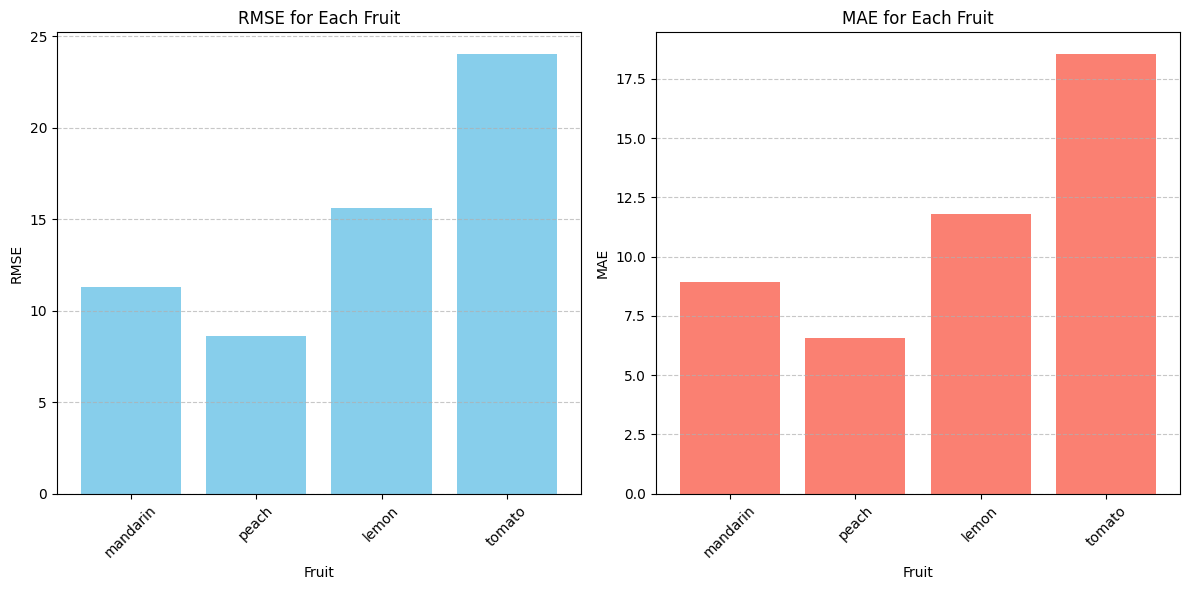

In [62]:
# Initialize dictionaries to store predictions and true labels for each fruit
fruit_predictions = {}
fruit_true_labels = {}

# Collect predictions and true labels for each fruit
for prediction, true_label, filename in zip(
    predictions, true_labels, test_df["File name"]
):
    fruit_name = filename.split("_")[1]  # Extract fruit name from the filename

    # Append predictions and true labels to respective lists for each fruit
    if fruit_name not in fruit_predictions:
        fruit_predictions[fruit_name] = []
        fruit_true_labels[fruit_name] = []
    fruit_predictions[fruit_name].append(prediction)
    fruit_true_labels[fruit_name].append(true_label)

# Calculate RMSE and MAE for each fruit
fruit_rmse = {}
fruit_mae = {}
for fruit, pred_list in fruit_predictions.items():
    true_list = fruit_true_labels[fruit]
    mse = mean_squared_error(true_list, pred_list)
    mae = mean_absolute_error(true_list, pred_list)
    rmse = np.sqrt(mse)
    fruit_rmse[fruit] = rmse
    fruit_mae[fruit] = mae


# Plotting the RMSE and MAE values for each fruit
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(fruit_rmse.keys(), fruit_rmse.values(), color="skyblue")
plt.xlabel("Fruit")
plt.ylabel("RMSE")
plt.title("RMSE for Each Fruit")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(fruit_mae.keys(), fruit_mae.values(), color="salmon")
plt.xlabel("Fruit")
plt.ylabel("MAE")
plt.title("MAE for Each Fruit")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

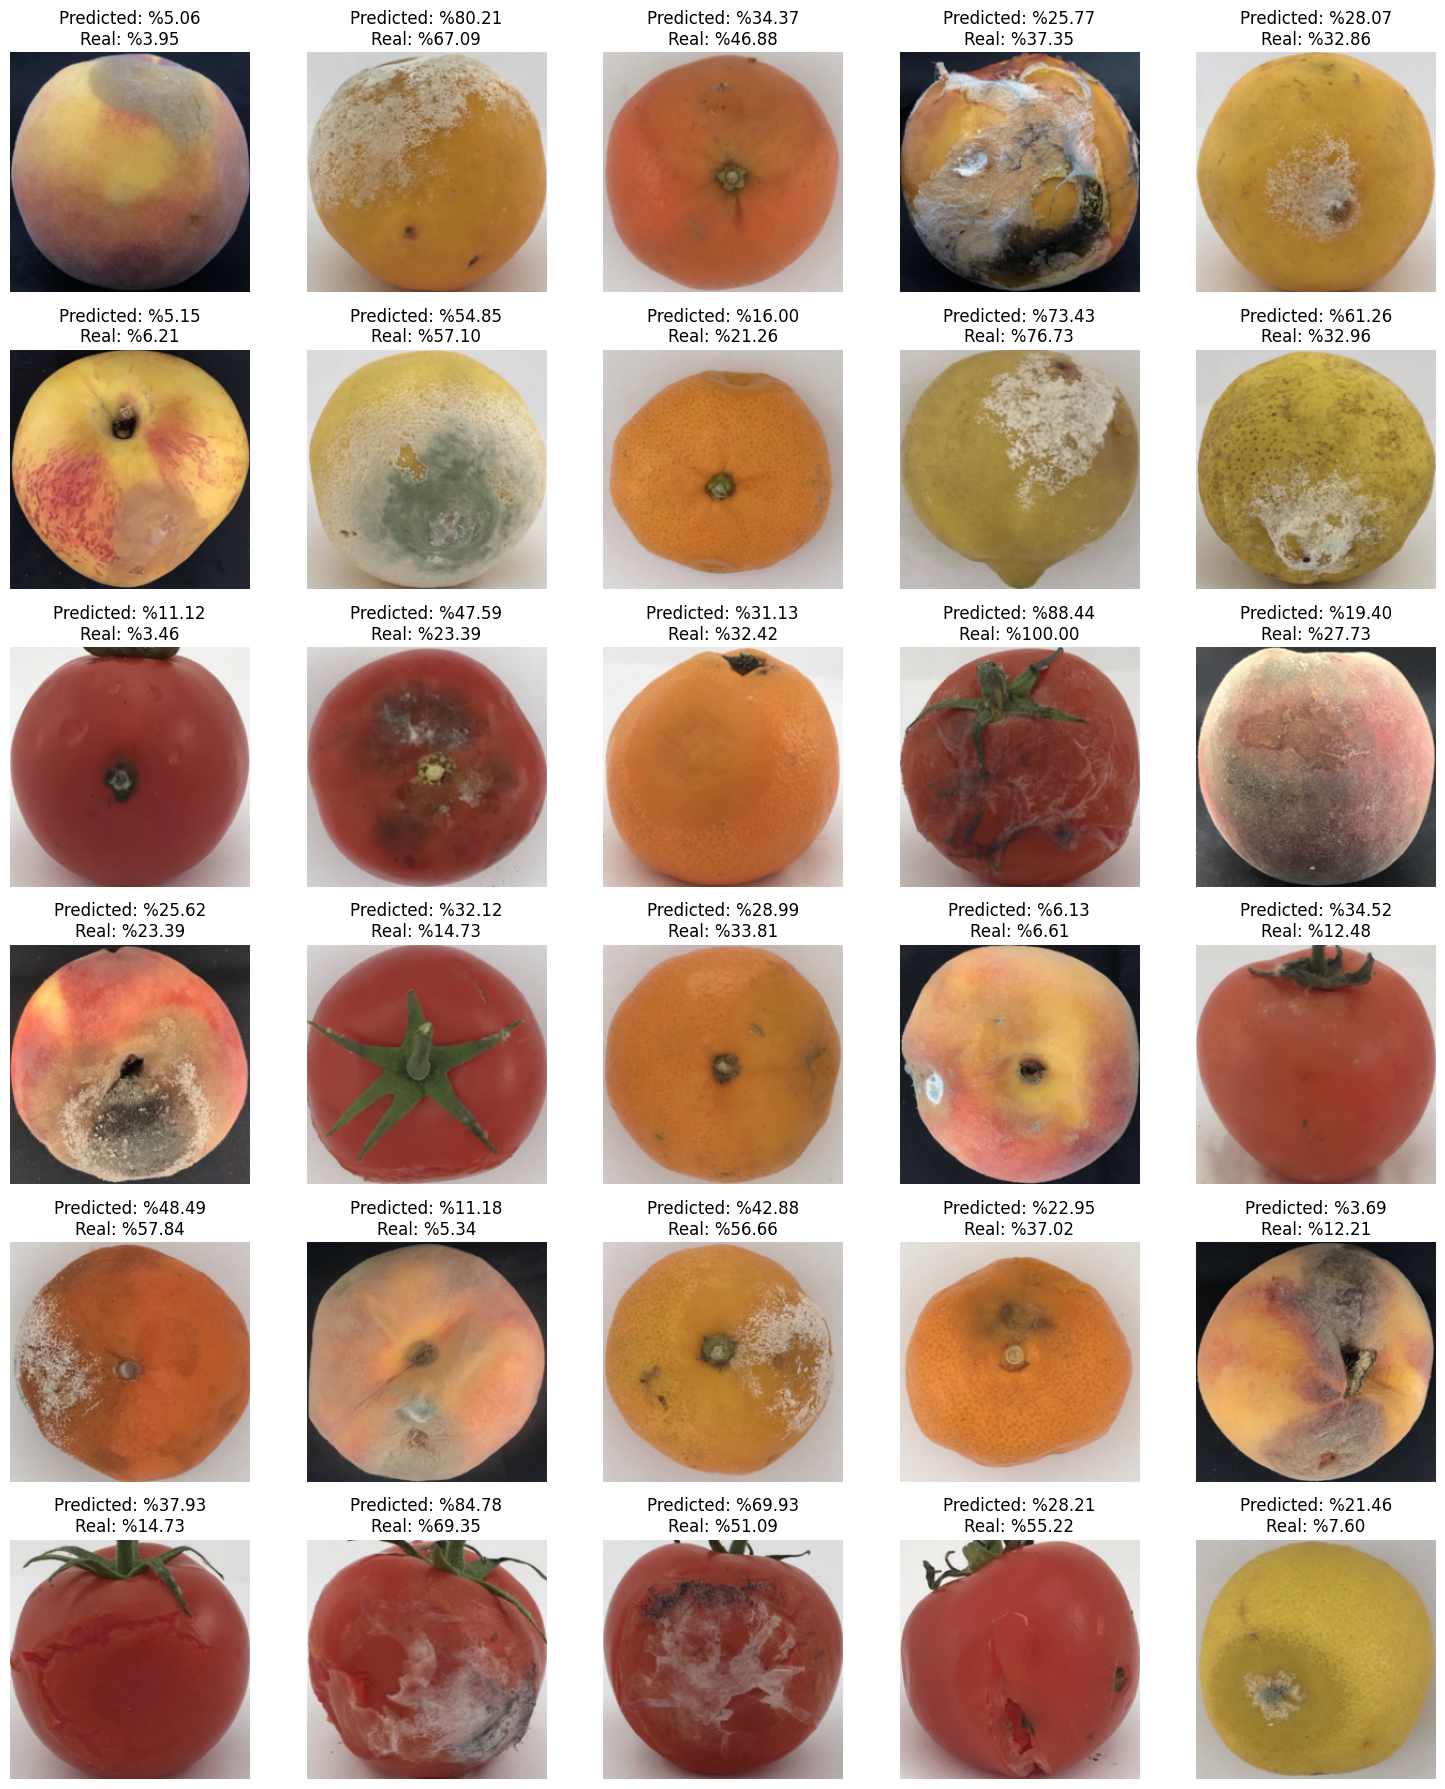

In [66]:
# Evaluation
model.eval()
with torch.no_grad():
    # Get random indices for 30 test images
    indices = np.random.choice(len(test_dataset), size=30, replace=False)

    # Create a subplot
    fig, axs = plt.subplots(6, 5, figsize=(15, 18))

    for i, idx in enumerate(indices):
        inputs, label = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        output = model(inputs)
        prediction = output.item()

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = inputs.squeeze().permute(1, 2, 0).cpu().numpy()
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Display the image
        axs[i // 5, i % 5].imshow(img)
        axs[i // 5, i % 5].set_title(
            f"Predicted: %{prediction:.2f}\nReal: %{label:.2f}"
        )
        axs[i // 5, i % 5].axis("off")

    plt.tight_layout()
    plt.show()